In [1]:
from typing import Annotated, List, Dict, Any, Literal
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama


In [2]:
llm = ChatOllama(model="gemma3:1b", temperature=0)

In [3]:
class CoTState(TypedDict):
    messages: Annotated[List[Any], "Messages in the conversation"]
    next_step: Literal["decompose", "step_1", "step_2", "step_3", "synthesize", "end"]
    problem: str
    steps: List[str]
    step_results: Dict[str, str]
    final_answer: str


In [4]:
def decompose_node(state: CoTState) -> Dict[str, Any]:
    """Break down the problem into sequential reasoning steps"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an expert problem solver. Break down complex problems into 3 clear, logical steps that would help solve it."),
        ("user", "Problem: {problem}\n\nProvide exactly 3 numbered steps (1, 2, 3) to solve this problem. Keep each step concise.")
    ])
    
    chain = prompt | llm | StrOutputParser()
    steps_text = chain.invoke({"problem": state["problem"]})
    
    # Parse steps (assuming they're numbered)
    steps = []
    for line in steps_text.split("\n"):
        if line.strip() and (line[0].isdigit() or "step" in line.lower()):
            steps.append(line.strip())
    
    # Ensure we have exactly 3 steps
    while len(steps) < 3:
        steps.append(f"Step {len(steps)+1}: Additional analysis required")
    
    return {
        "steps": steps[:3],  # Limit to 3 steps
        "next_step": "step_1"
    }


In [5]:
def execute_step_node(step_name: str, step_index: int):
    """Factory function to create step execution nodes"""
    def step_node(state: CoTState) -> Dict[str, Any]:
        current_step = state["steps"][step_index-1] if len(state["steps"]) >= step_index else f"Step {step_index}"
        
        # Include previous step results for context
        previous_results = ""
        for i in range(1, step_index):
            step_key = f"step_{i}"
            if step_key in state["step_results"]:
                previous_results += f"\nStep {i} result: {state['step_results'][step_key]}"
        
        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are solving a problem step by step. Provide a clear, logical answer for this specific step."),
            ("user", f"Original Problem: {state['problem']}\n{previous_results}\n\nCurrent Step: {current_step}\n\nProvide a detailed answer for this step:")
        ])
        
        chain = prompt | llm | StrOutputParser()
        step_result = chain.invoke({})
        
        # Update step results
        step_results = state.get("step_results", {}).copy()
        step_results[f"step_{step_index}"] = step_result
        
        # Determine next step
        next_step = f"step_{step_index+1}" if step_index < 3 else "synthesize"
        
        return {
            "step_results": step_results,
            "next_step": next_step
        }
    
    return step_node

In [6]:
def synthesize_node(state: CoTState) -> Dict[str, Any]:
    """Combine all steps into a coherent final answer"""
    # Prepare the reasoning chain
    reasoning_chain = f"Problem: {state['problem']}\n\n"
    reasoning_chain += "Reasoning Steps:\n"
    
    for i, step in enumerate(state["steps"], 1):
        step_key = f"step_{i}"
        step_result = state["step_results"].get(step_key, "No result available")
        reasoning_chain += f"{step}\nAnswer: {step_result}\n\n"
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are synthesizing a final answer based on step-by-step reasoning. Present a clear, concise final answer that incorporates all previous reasoning."),
        ("user", f"{reasoning_chain}\n\nBased on the above reasoning steps, provide a final comprehensive answer to the original problem:")
    ])
    
    chain = prompt | llm | StrOutputParser()
    final_answer = chain.invoke({})
    
    return {
        "final_answer": final_answer,
        "next_step": "end"
    }


In [7]:
def router(state: CoTState) -> str:
    """Determine which node to execute next"""
    return state["next_step"]

In [8]:
from langgraph.graph import StateGraph, END, START

builder = StateGraph(CoTState)

# Add nodes
builder.add_node("decompose", decompose_node)
builder.add_node("step_1", execute_step_node("step_1", 1))
builder.add_node("step_2", execute_step_node("step_2", 2))
builder.add_node("step_3", execute_step_node("step_3", 3))
builder.add_node("synthesize", synthesize_node)

# Add edges
builder.add_edge(START, "decompose")
builder.add_edge("decompose", "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", "synthesize")
builder.add_conditional_edges(
    "synthesize",
    router,
    {
        "end": END
    }
)

# Compile the graph
cot_graph = builder.compile()

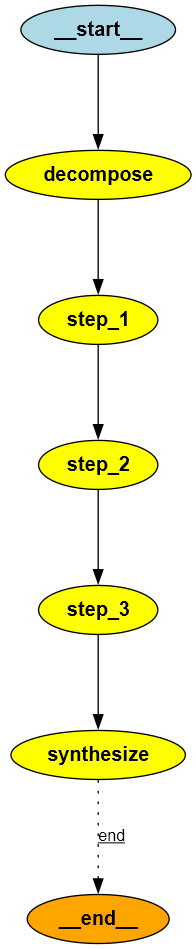

In [9]:
from IPython.display import Image, display
display(Image(cot_graph.get_graph().draw_png()))

In [10]:
def run_chain_of_thought(problem: str) -> Dict[str, Any]:
    """Run the Chain of Thought system with a problem"""
    initial_state = CoTState(
        messages=[HumanMessage(content=problem)],
        next_step="decompose",
        problem=problem,
        steps=[],
        step_results={},
        final_answer=""
    )
    
    result = cot_graph.invoke(initial_state)
    
    # Format the output for clarity
    output = {
        "problem": problem,
        "decomposed_steps": result["steps"],
        "step_by_step_reasoning": result["step_results"],
        "final_answer": result["final_answer"]
    }

    return output

In [11]:
math_problem = "A train leaves station A at 60 mph and another leaves station B at 40 mph towards A. If they are 300 miles apart, when do they meet?"
result1 = run_chain_of_thought(math_problem)

print("=== Chain of Thought Analysis ===")
print(f"Problem: {result1['problem']}\n")

print("Decomposed Steps:")
for i, step in enumerate(result1['decomposed_steps'], 1):
    print(f"  {i}. {step}")

print("\nStep-by-Step Reasoning:")
for step, answer in result1['step_by_step_reasoning'].items():
    print(f"  {step.replace('_', ' ').title()}: {answer}")

print(f"\nFinal Answer: {result1['final_answer']}")

print("\n" + "="*50 + "\n")

# Example 2: Logic problem
logic_problem = "If all Bloops are Razzies and all Razzies are Loppies, are all Bloops definitely Loppies?"
result2 = run_chain_of_thought(logic_problem)

print("=== Chain of Thought Analysis ===")
print(f"Problem: {result2['problem']}\n")

print("Decomposed Steps:")
for i, step in enumerate(result2['decomposed_steps'], 1):
    print(f"  {i}. {step}")

print("\nStep-by-Step Reasoning:")
for step, answer in result2['step_by_step_reasoning'].items():
    print(f"  {step.replace('_', ' ').title()}: {answer}")

print(f"\nFinal Answer: {result2['final_answer']}")

=== Chain of Thought Analysis ===
Problem: A train leaves station A at 60 mph and another leaves station B at 40 mph towards A. If they are 300 miles apart, when do they meet?

Decomposed Steps:
  1. Here’s a breakdown of the problem into 3 steps:
  2. 1. **Determine the combined speed:** Calculate the combined speed at which the trains are approaching each other. Add the speeds of each train – 60 mph + 40 mph = 100 mph.
  3. 2. **Calculate the time to meet:** Divide the distance between the stations (300 miles) by the combined speed to find the time it takes for them to meet. 300 miles / 100 mph = 3 hours.

Step-by-Step Reasoning:
  Step 1: Okay, let’s break this problem down into three steps:

**Step 1: Determine the Combined Speed**

Since the trains are moving towards each other, we need to find their combined speed.  We can do this by adding their speeds: 60 mph + 40 mph = 100 mph.

**Step 2: Calculate the Time to Meet**

Now we can use the formula: Time = Distance / Speed.  We kn